In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# date of datas
date = "0913"

# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# dir
first_order_data_dir = './calibration/first_order_position_line_pattern/2023%s'%date

# center points for all patches
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])

In [3]:
wvls

array([430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550,
       560, 570, 580, 590, 600, 610, 620, 640, 650, 660])

### Captured line pattern images with BPF

In [4]:
first_order_data = []

exp_indx = 1

for i in range(318): 
    first_order_dir = os.path.join(first_order_data_dir, '%snm_crop/calibration00/capture_%04d.png')

    first_order_imgs = np.array([cv2.imread(first_order_dir%(wvls[w], i), -1)[:,:,::-1] for w in range(len(wvls))])
    first_order_data.append(first_order_imgs)
    
first_order_data = np.array(first_order_data) # 318, 25, 580, 890, 3

In [8]:
first_order_data.shape # illumination index, wvls, H, W, rgb

(318, 23, 580, 890, 3)

In [9]:
first_order_data_transposed = first_order_data.transpose(2,3,0,1,4)
print(first_order_data_transposed.shape) # H, W, illumination index, wvls, rgb

(580, 890, 318, 23, 3)


### Save data for each patches for each wavelengths

In [16]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, len(wvls)))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 3

# max value defined for each illumination pattern 

for w in range(len(wvls)):
    for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
            
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (first_order_data_transposed[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l, w] / (65535)).reshape(-1, 3).mean(axis = 0)
                max_idx = np.argmax(rgb_intensity) # rgb 채널 중 max 값 넣기

                patches_rgb_real[l, p, w] = rgb_intensity[max_idx] # illum index, patch, wvls

### Find first order dispersed light peak illumination index

In [60]:
peak_illum_idx = np.zeros(shape=(n_patches, len(wvls)))

In [50]:
np.argmax(patches_rgb_real[:220,17, 0])

163

In [55]:
patches_rgb_real[:,18, 0].min()

0.05835049973296712

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


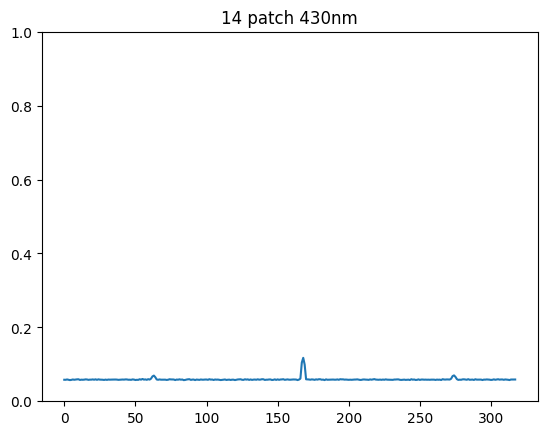

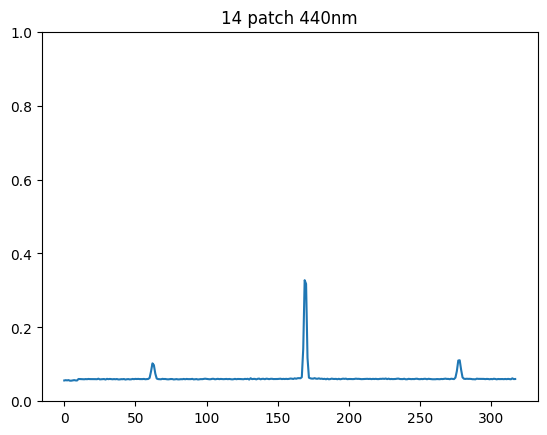

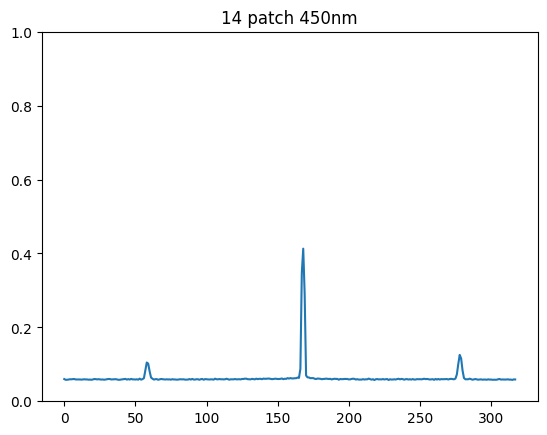

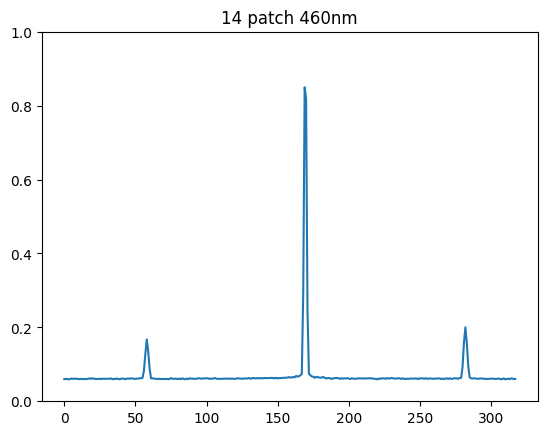

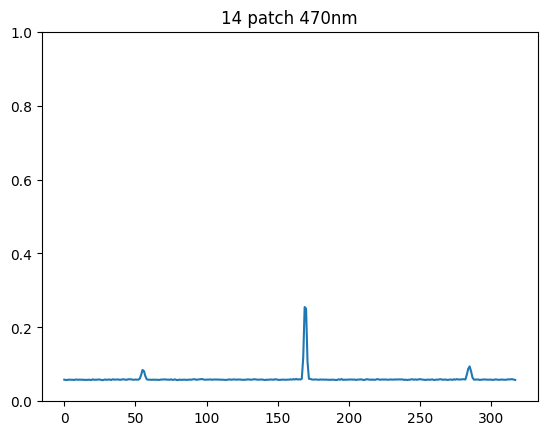

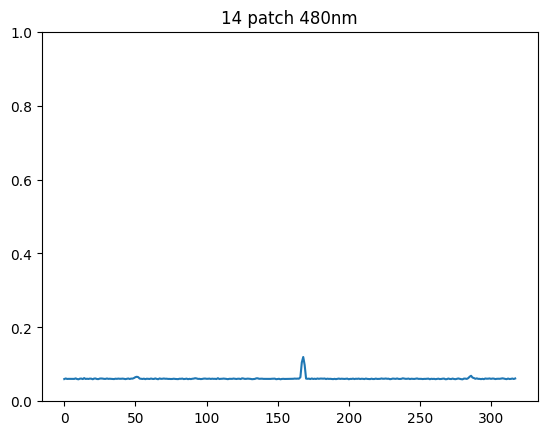

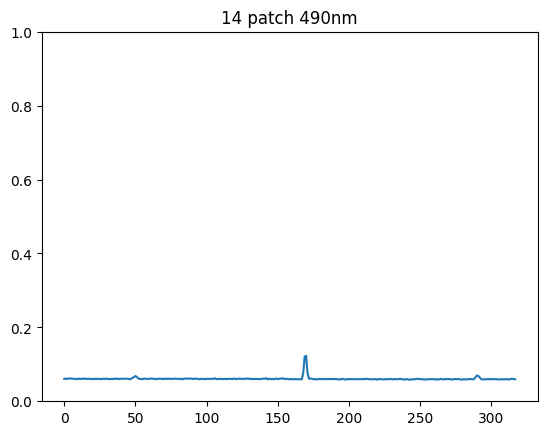

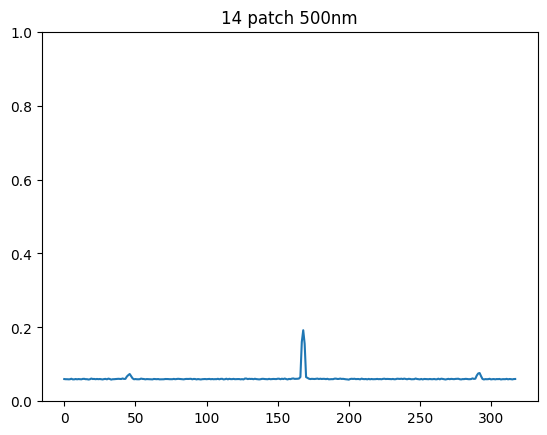

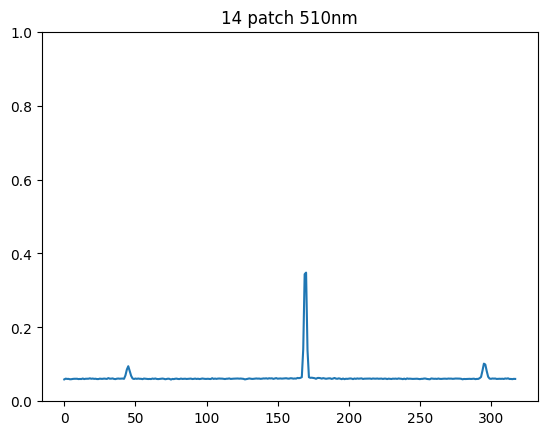

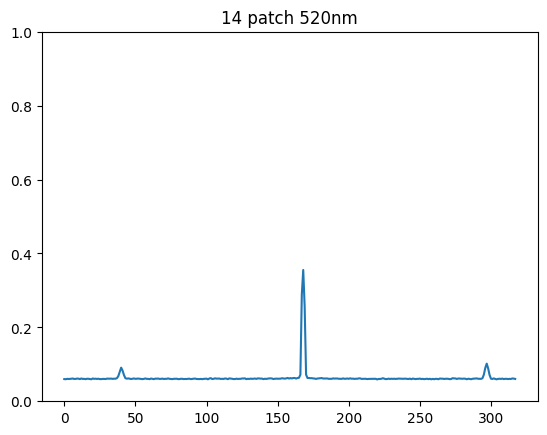

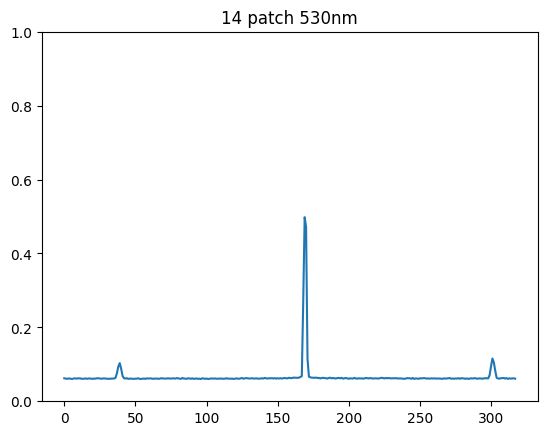

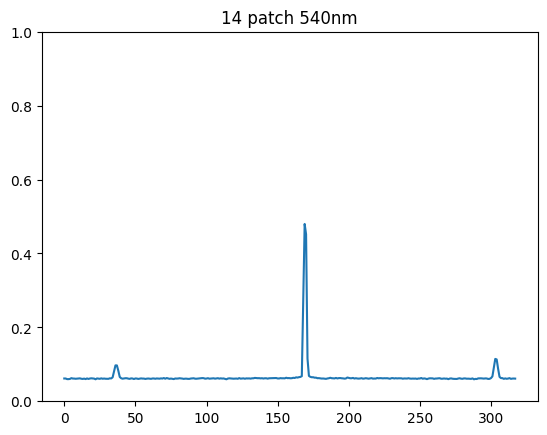

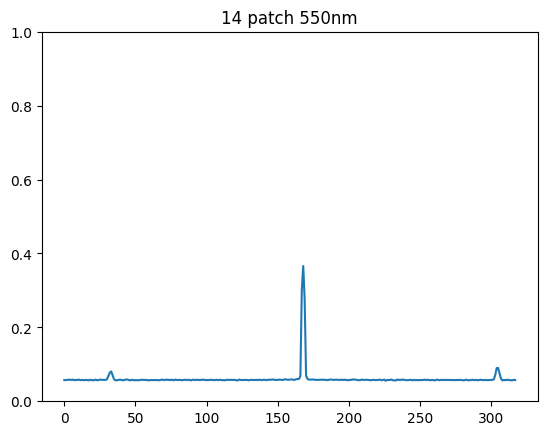

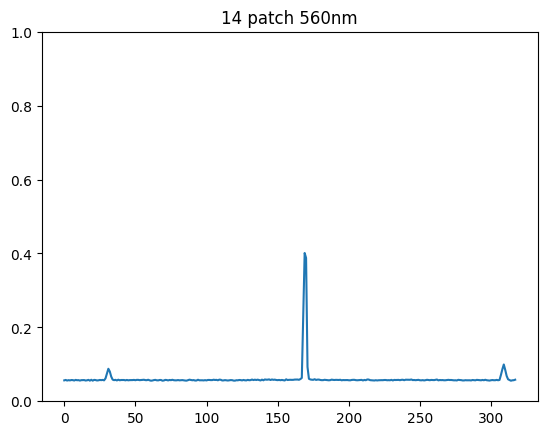

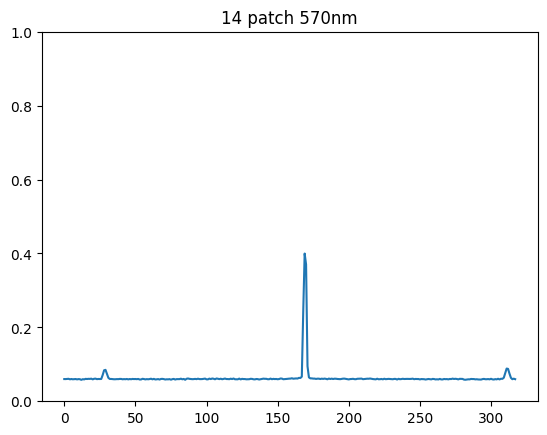

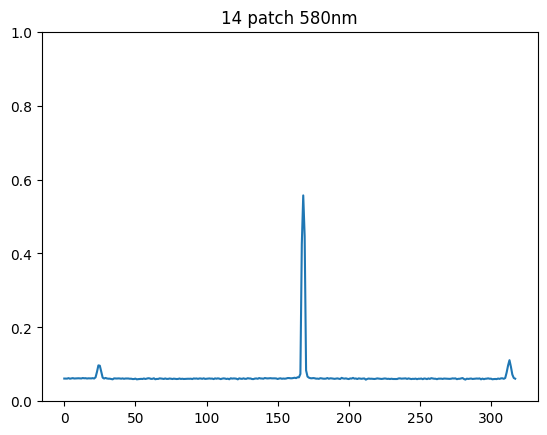

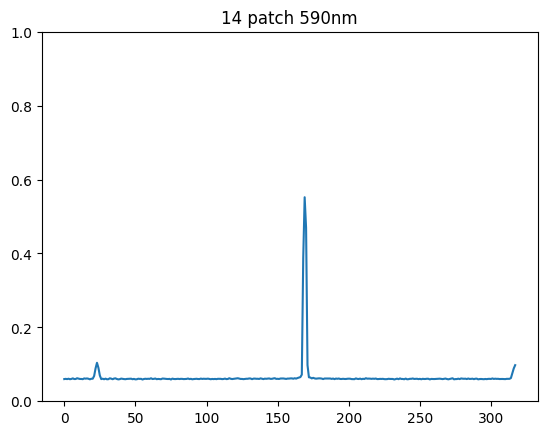

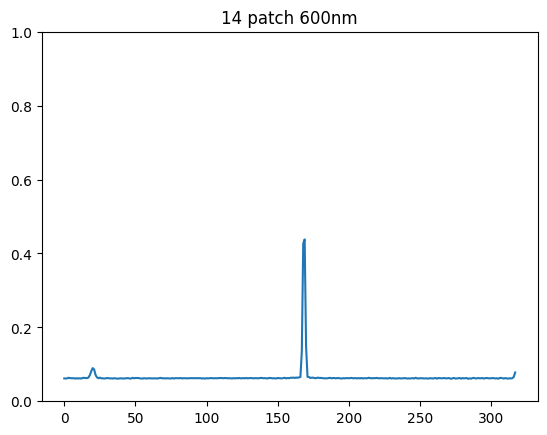

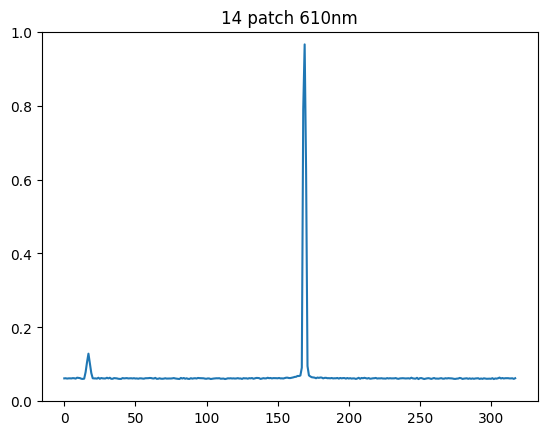

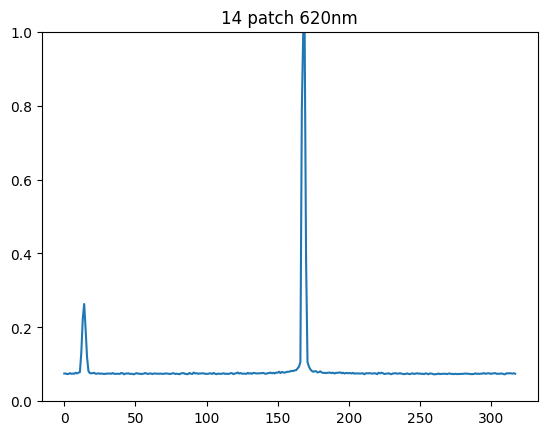

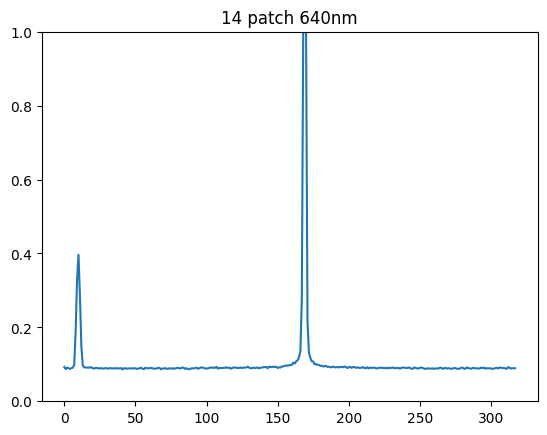

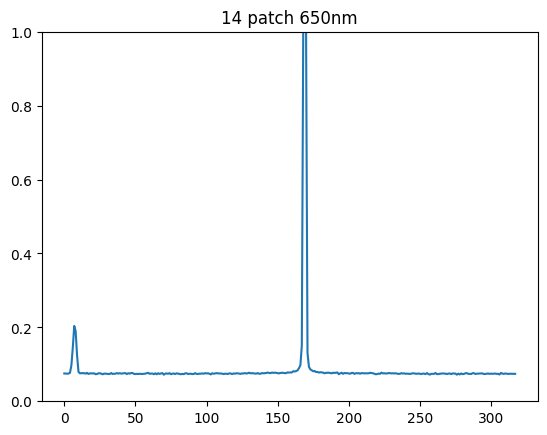

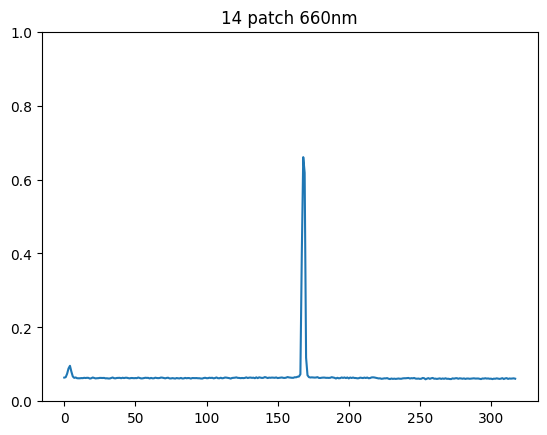

In [98]:
# patches_rgb_real (318, 24, 23)

zero_idx = 150

for p in range(14,15):
    for w in range(len(wvls)):
        plt.figure()
        plt.ylim([0, 1])
        plt.plot(patches_rgb_real[:,p, w]), plt.title('%02d patch %dnm'%(p, wvls[w]))
        
        # # for +1 orders
        # max_idx = np.argmax(patches_rgb_real[zero_idx:,p, w]) + zero_idx
        # peak_illum_idx[p, w] = max_idx
        
        # # for -1 orders
        # max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
        # peak_illum_idx[p, w] = max_idx

In [99]:
np.argmax(patches_rgb_real[:,14,0])

168

In [ ]:
# 18 : 203 - 260 // zero 101
# 17 : 163 - 110 // zero 268
# 12 : 204 - 258 // zero 99
# 13 : 239 - 297 // zero 134
# 14 : 63 - 4 // zero 168

[430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600
 610 620 640 650 660]
[63. 62. 58. 58. 55. 51. 50. 46. 45. 40. 39. 36. 33. 31. 29. 24. 23. 20.
 17. 14. 10.  7.  4.]


([<matplotlib.lines.Line2D at 0x13782c37288>], Text(0.5, 1.0, '14 patch'))

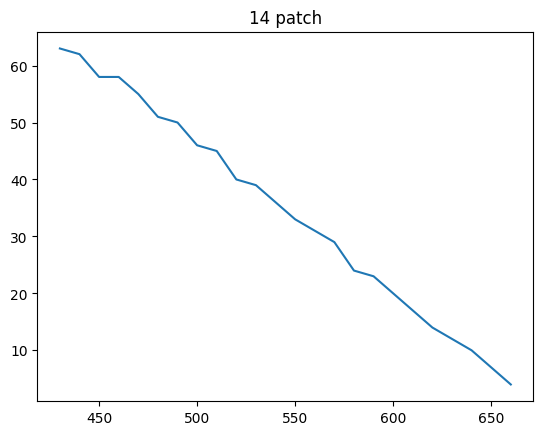

In [100]:
patch_idx = 14

print(wvls)
print(peak_illum_idx[patch_idx])
plt.plot(wvls, peak_illum_idx[patch_idx]), plt.title('%02d patch'%patch_idx)

In [101]:
np.save('./peak_illum_idx.npy', peak_illum_idx)